# Imports

In [1]:
# ==========================================
# Basic Libraries
# ==========================================
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import display, HTML

# ==========================================
# Scikit-learn General
# ==========================================
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import make_pipeline

# ==========================================
# Scikit-learn Preprocessing & Transformation
# ==========================================
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel, RFECV

# ==========================================
# Scikit-learn Regressors
# ==========================================
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# ==========================================
# External Regressors & Libraries
# ==========================================
import xgboost as xgb
from xgboost import XGBRegressor

# ==========================================
# Miscellaneous Settings
# ==========================================
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [2]:
houses = pd.read_csv('/Users/merlesteffen/Documents/GitHub/HousingPricePrediction/Data/Kaggle_Data/house-prices-advanced-regression-techniques/train.csv')

In [3]:
houses.drop(columns=['Id'], inplace=True)

In [4]:
houses['MSSubClass'] = houses['MSSubClass'].astype('object')
#Changing OverallCond into a categorical variable
houses['OverallCond'] = houses['OverallCond'].astype('object')

In [5]:
# Outliers
houses.drop(houses[houses['GrLivArea'] >= 4000].index, inplace=True)

# Split Data

In [53]:
X = houses.copy()
X.drop(columns='SalePrice', inplace=True)
y = np.log1p(houses['SalePrice'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Missing Values

In [54]:
# Temporarily set the display options to show all rows
pd.set_option('display.max_rows', None)

# Display the NaN counts for all columns
print(X_train.isna().sum())

# Reset the display options back to default settings
pd.reset_option('display.max_rows')

MSSubClass          0
MSZoning            0
LotFrontage       221
LotArea             0
Street              0
Alley            1094
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          5
MasVnrArea          5
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           30
BsmtCond           30
BsmtExposure       31
BsmtFinType1       30
BsmtFinSF1          0
BsmtFinType2       30
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea 

In [55]:
# After inspection we find that where there is not fireplace fireplacequ was set to missing instead of 'NA'
X_train.loc[X_train['Fireplaces'] == 0, 'FireplaceQu'] = 'NA'

In [56]:
garage_null_rows = X_train[X_train['GarageCond'].isnull()]

# Display just the garage-related columns for these rows
garage_columns = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']
garage_null_rows[garage_columns]

# Let us reset the columns to 'NA'

# List of columns to update
cols_to_update = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

# Set those columns to 'NA' where GarageArea is 0
X_train.loc[X_train['GarageArea'] == 0, cols_to_update] = 'NA'
X_train.loc[X_train['GarageArea'] == 0, 'GarageYrBlt'] = -9999

In [57]:
pool_null_rows = X_train[X_train['PoolQC'].isnull()]

# Display just the pool-related columns for these rows
pool_columns = ['PoolArea', 'PoolQC']
pool_null_rows[pool_columns]

# Just as I thought, let us replace the missing values with 'NA'
X_train.loc[X_train['PoolArea'] == 0, 'PoolQC'] = 'NA'

In [58]:
# Let us check the Fence
X_train[X_train['Fence'] == 'NA']
X_train['Fence'].fillna('NA', inplace=True)

In [59]:
# MiscFeature
X_train[X_train['MiscFeature'] == 'NA']
X_train['MiscFeature'].fillna('NA', inplace=True)

In [60]:
# Alley
X_train[X_train['Alley'] == 'NA']
X_train['Alley'].fillna('NA', inplace=True)

In [61]:
# Doesnt work for LotFrontage so it will be needed to use SimpleImputer

In [62]:
# Electrical we dont know, so since it is only one observation

In [63]:
# All Basement Columns
no_basement_rows = X_train[X_train['TotalBsmtSF'] == 0]

# Define the list of basement-related columns
bsmt_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 
                'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']

# Display the values in the basement-related columns for these rows
no_basement_rows[bsmt_columns]

# List of columns to update based on your provided list
bsmt_columns_to_update = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

X_train.loc[X_train['TotalBsmtSF'] == 0, bsmt_columns_to_update] = 'NA'

In [64]:
# MasVnrType & MasVnrArea have each five missing values, which are in the same observations, 
# so I will experiment around with this, maybe drop them or impute them, we will see.

In [65]:
# Calculate variance
variance = X_train.var()

# Sort variance from lowest to highest
sorted_variance = variance.sort_values()

# Round to 5 decimal places and format to display in full
formatted_variance = sorted_variance.round(5).apply(lambda x: '{:.5f}'.format(x))

print(formatted_variance)

KitchenAbvGr             0.04927
BsmtHalfBath             0.05829
HalfBath                 0.25395
BsmtFullBath             0.26645
FullBath                 0.30163
Fireplaces               0.40234
GarageCars               0.55128
BedroomAbvGr             0.66209
OverallCond              1.22695
YrSold                   1.76874
OverallQual              1.86967
TotRmsAbvGrd             2.54258
MoSold                   7.25700
YearRemodAdd           428.48146
LotFrontage            548.05704
YearBuilt              916.66440
3SsnPorch              988.91576
PoolArea              1565.03274
MSSubClass            1769.91404
LowQualFinSF          1944.09404
ScreenPorch           3115.63053
EnclosedPorch         3543.36386
OpenPorchSF           4336.34979
WoodDeckSF           15826.57456
BsmtFinSF2           24856.43706
MasVnrArea           29385.39845
GarageArea           45603.52832
1stFlrSF            134230.38318
TotalBsmtSF         170925.86551
2ndFlrSF            187382.30205
BsmtFinSF1

### Correlation

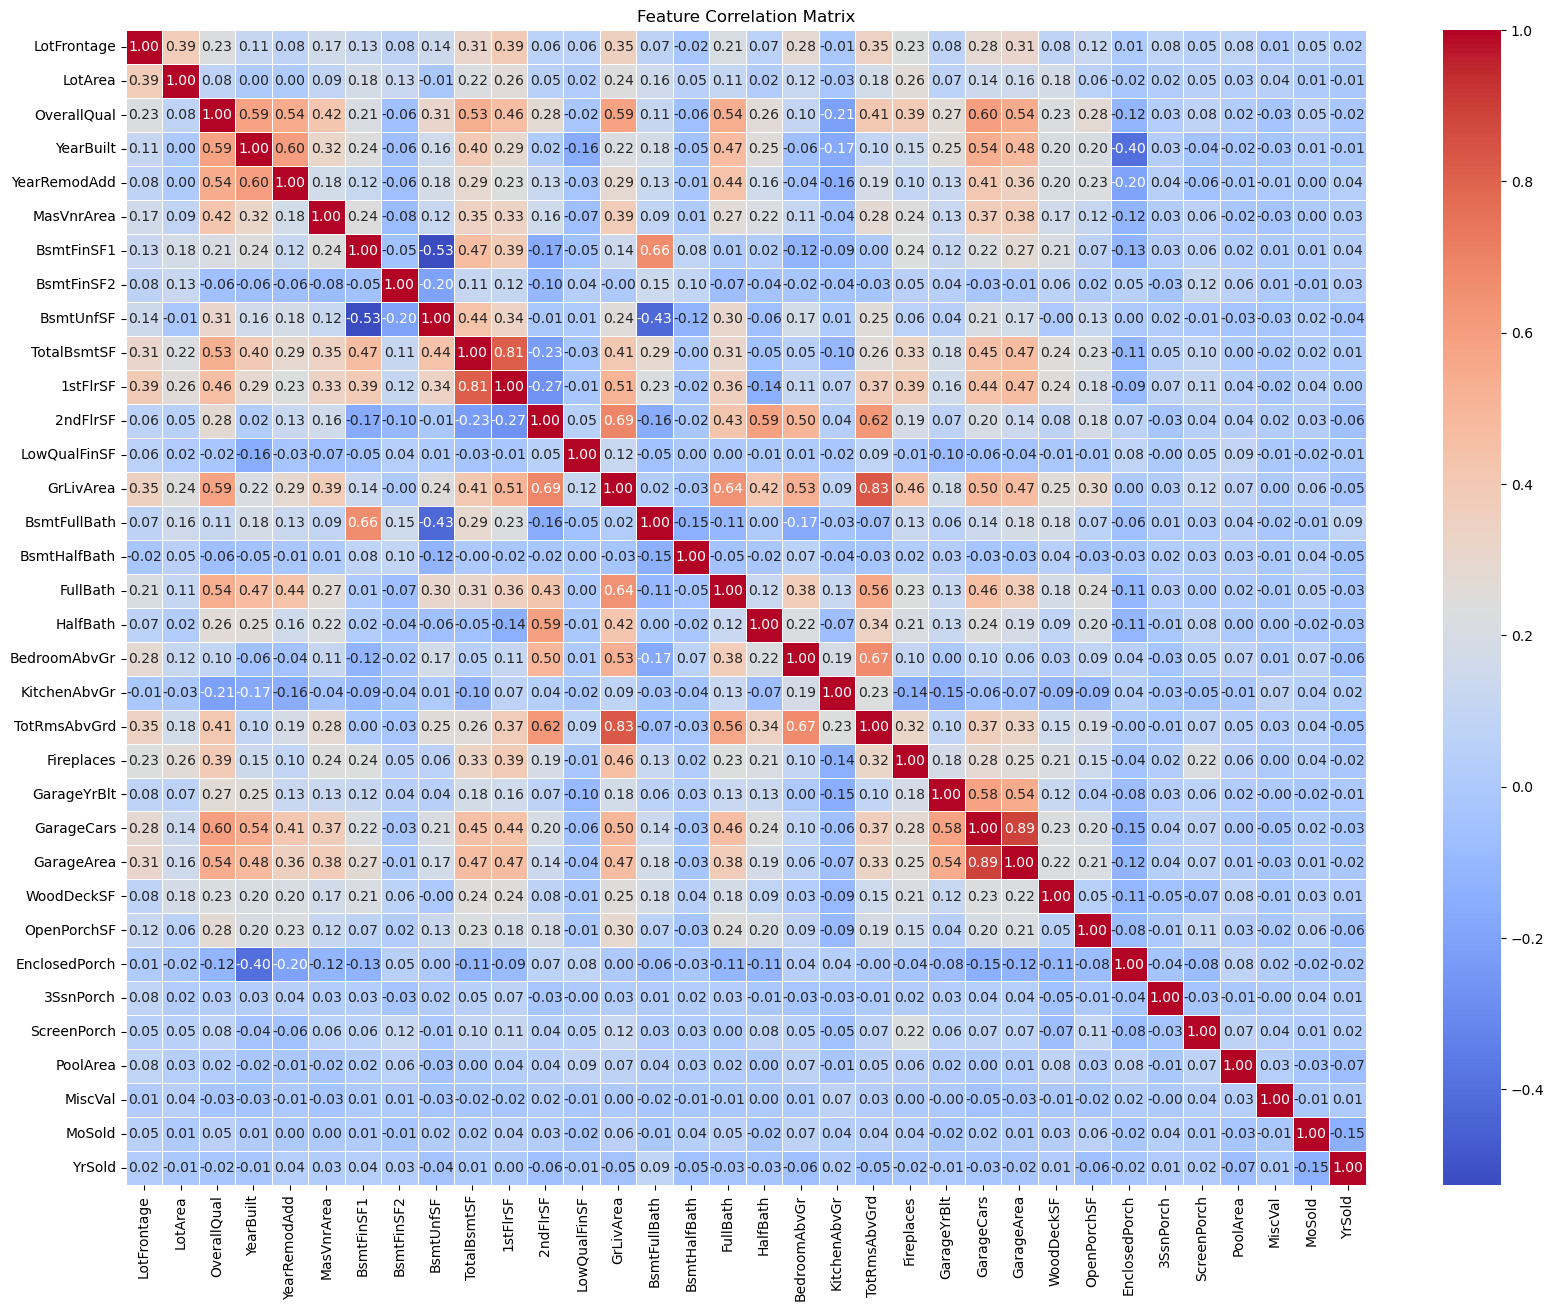

In [66]:
# Compute the correlation matrix
corr = X_train.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# Generate a heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='white')

plt.title('Feature Correlation Matrix')
plt.show()

Maybe drop Garage Cars, since it has the lower Variance and is highly correlated with Garage Area.
The Rest looks great.

## Independent Vriable Normalize

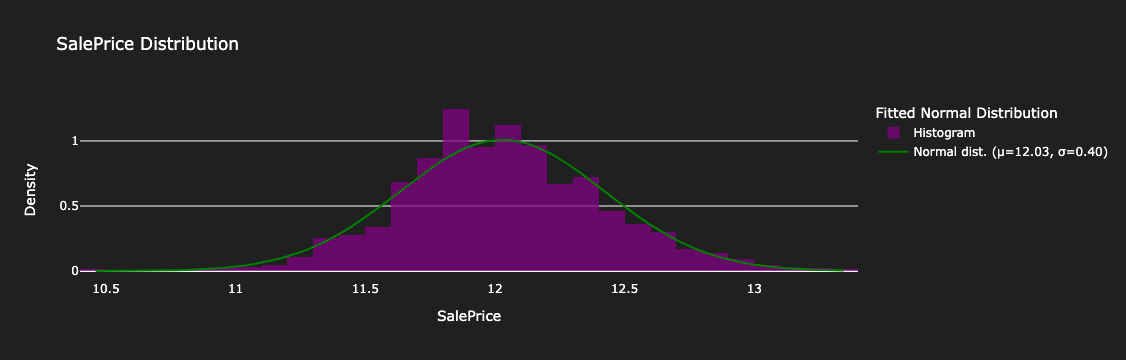

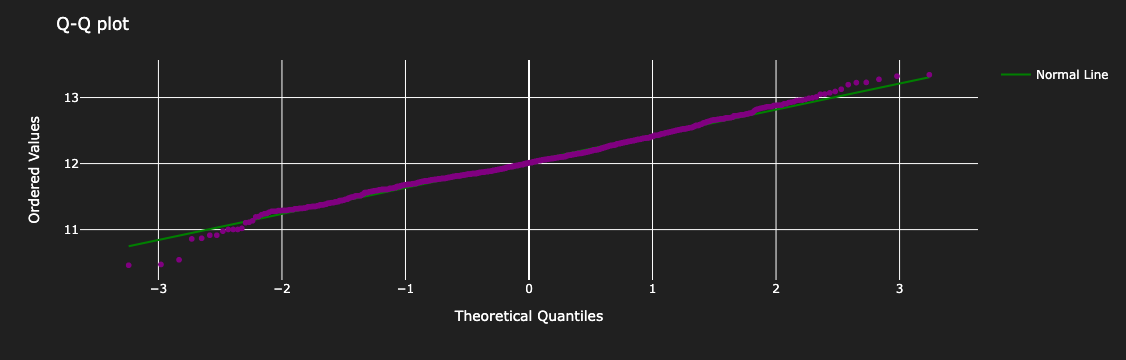

In [67]:
import scipy.stats as stats

# Fit a normal distribution to the SalePrice data
mu, sigma = stats.norm.fit(y_train)

# Create a histogram of the SalePrice column
hist_data = go.Histogram(x=y_train, nbinsx=50, name="Histogram", opacity=0.75, histnorm='probability density', marker=dict(color='purple'))

# Calculate the normal distribution based on the fitted parameters
x_norm = np.linspace(y_train.min(), y_train.max(), 100)
y_norm = stats.norm.pdf(x_norm, mu, sigma)

# Create the normal distribution overlay
norm_data = go.Scatter(x=x_norm, y=y_norm, mode="lines", name=f"Normal dist. (μ={mu:.2f}, σ={sigma:.2f})", line=dict(color="green"))

# Combine the histogram and the overlay
fig = go.Figure(data=[hist_data, norm_data])

# Set the layout for the plot
fig.update_layout(
    title="SalePrice Distribution",
    xaxis_title="SalePrice",
    yaxis_title="Density",
    legend_title_text="Fitted Normal Distribution",
    plot_bgcolor='rgba(32, 32, 32, 1)',
    paper_bgcolor='rgba(32, 32, 32, 1)',
    font=dict(color='white')
)

# Create a Q-Q plot
qq_data = stats.probplot(y_train, dist="norm")
qq_fig = px.scatter(x=qq_data[0][0], y=qq_data[0][1], labels={'x': 'Theoretical Quantiles', 'y': 'Ordered Values'}, color_discrete_sequence=["purple"])
qq_fig.update_layout(
    title="Q-Q plot",
    plot_bgcolor='rgba(32, 32, 32, 1)',
    paper_bgcolor='rgba(32, 32, 32, 1)',
    font=dict(color='white')
)

# Calculate the line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(qq_data[0][0], qq_data[0][1])
line_x = np.array(qq_data[0][0])
line_y = intercept + slope * line_x

# Add the line of best fit to the Q-Q plot
line_data = go.Scatter(x=line_x, y=line_y, mode="lines", name="Normal Line", line=dict(color="green"))

# Update the Q-Q plot with the normal line
qq_fig.add_trace(line_data)

# Show the plots
fig.show()
qq_fig.show()

Use Log Transformation later on since the Data are skewed.

# Preprocess Data

 Let us remember the LotFrontage is the only one with missing values.

In [68]:
num_features = X_train.select_dtypes(exclude=['object']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

## Encoding

In [69]:
# Define orders
order_ExterQual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_ExterCond = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtQual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtCond = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtExposure = ['NA', 'No', 'Mn', 'Av', 'Gd']
order_BsmtFinType1 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
order_BsmtFinType2 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
order_HeatingQC = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_KitchenQual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_Functional = ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
order_FireplaceQu = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_GarageFinish = ['NA', 'Unf', 'RFn', 'Fin']
order_GarageQual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_GarageCond = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_PavedDrive = ['N', 'P', 'Y']
order_PoolQC = ['NA', 'Fa', 'TA', 'Gd', 'Ex']
order_Fence = ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']

# Setup the encoder
ordinal_enc = OrdinalEncoder(
    categories=[
        order_ExterQual, order_ExterCond, order_BsmtQual, order_BsmtCond, 
        order_BsmtExposure, order_BsmtFinType1, order_BsmtFinType2, order_HeatingQC, 
        order_KitchenQual, order_Functional, order_FireplaceQu, order_GarageFinish, order_GarageQual, 
        order_GarageCond, order_PavedDrive, order_PoolQC, order_Fence
    ],
    handle_unknown='use_encoded_value',
    unknown_value=-1
)


In [70]:
cat_ordinal = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
    'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 
    'GarageCond', 'PavedDrive', 'PoolQC', 'Fence'
]
cat_onehot = [col for col in cat_features if col not in cat_ordinal]

## Pipelines

### Select From Model

In [71]:
num_pipeline = make_pipeline(
    SimpleImputer(strategy='mean')
)

cat_ordinal_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    ordinal_enc
)

cat_onehot_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
)

In [72]:
preprocessor = ColumnTransformer(transformers=[
    ('num_pipe', num_pipeline, num_features),
    ('onehot', cat_onehot_pipe, cat_onehot),
    ('ordinal', cat_ordinal_pipe, cat_ordinal)
])

In [73]:
# feature engineering functions 
def custom_features(df):
    df_out = df.copy()
    df_out['PropertyAge'] = df_out['YrSold'] - df_out['YearBuilt']
    df_out['TotalSF'] = df_out['TotalBsmtSF'] + df_out['1stFlrSF'] + df_out['2ndFlrSF']
    df_out['TotalBath'] = df_out['FullBath'] + 0.5 * df_out['HalfBath'] + df_out['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    df_out['HasRemodeled'] = (df_out['YearRemodAdd'] != df_out['YearBuilt']).astype(object)
    df_out['Has2ndFloor'] = (df_out['2ndFlrSF'] > 0).astype(object)
    df_out['HasGarage'] = (df_out['GarageArea'] > 0).astype(object)
    df_out['YrSold_cat'] = df_out['YrSold'].astype(object)
    df_out['MoSold_cat'] = df_out['MoSold'].astype(object)
    df_out['YearBuilt_cat'] = df_out['YearBuilt'].astype(object)
    df_out['MSSubClass_cat'] = df_out['MSSubClass'].astype(object)
    
    return df_out

feature_engineering_transformer = FunctionTransformer(custom_features)

## GradientBoostingRegressor

In [77]:
# Best Model so far
model_GBR =  GradientBoostingRegressor(n_estimators=1100, loss='squared_error', subsample = 0.35, learning_rate = 0.05,random_state=1)
GBR_Pipeline = make_pipeline(feature_engineering_transformer, preprocessor, StandardScaler(), model_GBR)
GBR_Pipeline.fit(X_train, y_train)
preds_GBR = GBR_Pipeline.predict(X_test)

predictions = GBR_Pipeline.predict(X_test)
mae = mean_absolute_error(y_true=y_test, y_pred=predictions).round(2)
rmse = mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=predictions)
r2 = r2_score(y_true=y_test, y_pred=predictions)

model_df = pd.DataFrame({
    "MAE": [mae],
    "RMSE": [rmse],
    "MAPE": [mape],
    "R2": [r2]},
)
model_df

,MAE,RMSE,MAPE,R2
0,0.08,0.1284,0.007099,0.895613


#### Submitting

In [78]:
new_data = pd.read_csv('/Users/merlesteffen/Documents/GitHub/HousingPricePrediction/Data/Kaggle_Data/house-prices-advanced-regression-techniques/test.csv')
id_col = new_data.pop('Id')

In [79]:
new_data['MSSubClass'] = new_data['MSSubClass'].astype('object')
houses['OverallCond'] = houses['OverallCond'].astype('object')

In [28]:
GBR_Pipeline.fit(X,y)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function custom_features at 0x2ae9b1ee0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtS...
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'FireplaceQu',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PoolQC',
                                                   'Fence'])])),
                ('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=4,
                                           min_samples_leaf=3,
                                           n_estimators=1200, random_state=1,
                                           subsample=0.35))])

In [30]:
prices_log = GBR_Pipeline.predict(new_data)
prices = np.expm1(prices_log)
prices

In [32]:
submission_file = pd.DataFrame({
    'Id':id_col,
    'SalePrice':prices
})
submission_file

,Id,SalePrice
0,1461,126582.183082
1,1462,158068.364259
2,1463,182399.835732
3,1464,190542.523598
4,1465,189938.056346
...,...,...
1454,2915,81944.346958
1455,2916,80389.032134
1456,2917,161125.973645
1457,2918,117429.395181


In [33]:
submission_file.to_csv('/Users/merlesteffen/Documents/GitHub/HousingPricePrediction/Data/Submissions/submission_new.csv',index=False)

## Grid Search

In [ ]:
# Define the parameter grid
param_grid = {
    'gradientboostingregressor__n_estimators': [1000, 1100, 1200],
    'gradientboostingregressor__learning_rate': [0.01, 0.05, 0.1],
    'gradientboostingregressor__subsample': [0.3, 0.35, 0.4],
    'gradientboostingregressor__max_depth': [3, 4, 5],
    'gradientboostingregressor__min_samples_split': [2, 3, 4],
    'gradientboostingregressor__min_samples_leaf': [1, 2, 3]
    # Add more parameters if needed
}

# Create the grid search object
grid_search = GridSearchCV(GBR_Pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-2, verbose=1)

# Fit to the data
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict using the best model
predictions = best_model.predict(X_test)
mae = mean_absolute_error(y_true=y_test, y_pred=predictions).round(2)
rmse = mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=predictions)
r2 = r2_score(y_true=y_test, y_pred=predictions)

model_df = pd.DataFrame({
    "MAE": [mae],
    "RMSE": [rmse],
    "MAPE": [mape],
    "R2": [r2]},
)
model_df


Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was rename

# Submitting

In [78]:
new_data = pd.read_csv('/Users/merlesteffen/Documents/GitHub/HousingPricePrediction/Data/Kaggle_Data/house-prices-advanced-regression-techniques/test.csv')
id_col = new_data.pop('Id')

In [79]:
new_data['MSSubClass'] = new_data['MSSubClass'].astype('object')
houses['OverallCond'] = houses['OverallCond'].astype('object')

In [28]:
best_model.fit(X,y)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function custom_features at 0x2ae9b1ee0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtS...
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'FireplaceQu',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PoolQC',
                                                   'Fence'])])),
                ('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=4,
                                           min_samples_leaf=3,
                                           n_estimators=1200, random_state=1,
                                           subsample=0.35))])

In [31]:
prices_log = best_model.predict(new_data)
prices = np.expm1(prices_log)
prices

array([126582.18308187, 158068.36425871, 182399.83573189, ...,
       161125.97364514, 117429.39518148, 223138.92972809])

In [32]:
submission_file = pd.DataFrame({
    'Id':id_col,
    'SalePrice':prices
})
submission_file

,Id,SalePrice
0,1461,126582.183082
1,1462,158068.364259
2,1463,182399.835732
3,1464,190542.523598
4,1465,189938.056346
...,...,...
1454,2915,81944.346958
1455,2916,80389.032134
1456,2917,161125.973645
1457,2918,117429.395181


In [33]:
submission_file.to_csv('/Users/merlesteffen/Documents/GitHub/HousingPricePrediction/Data/Submissions/submission_new.csv',index=False)

# Regression Stacking

In [34]:
# Define base models
base_models = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42)),
    ('gbr', GradientBoostingRegressor(random_state=42))
]


# Using Ridge as the meta-regressor
stacked_regressor = StackingRegressor(estimators=base_models, final_estimator=Ridge(alpha=1.0, random_state=42), cv=5)

pipeline = make_pipeline(feature_engineering_transformer, preprocessor, StandardScaler(), stacked_regressor)

# Train the stacking classifier
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_true=y_test, y_pred=predictions).round(2)
rmse = mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=predictions)
r2 = r2_score(y_true=y_test, y_pred=predictions)

model_df = pd.DataFrame({
    "MAE": [mae],
    "RMSE": [rmse],
    "MAPE": [mape],
    "R2": [r2]},
)
model_df

,MAE,RMSE,MAPE,R2
0,0.09,0.129803,0.007436,0.893322


In [35]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
# You can define specific parameters for your base models and the meta-regressor
param_grid = {
    'stackingregressor__rf__n_estimators': [10, 100],
    'stackingregressor__xgb__learning_rate': [0.01, 0.1],
    'stackingregressor__final_estimator__alpha': [0.1, 1.0, 10.0]  # parameters for Ridge
}

# Initialize GridSearchCV with the scoring method set to 'neg_mean_squared_error'
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Fit the grid search
grid.fit(X_train, y_train)

# Get the best pipeline
best_pipeline = grid.best_estimator_

# Predict using the best pipeline
y_pred = best_pipeline.predict(X_test)

predictions = best_pipeline.predict(X_test)
mae = mean_absolute_error(y_true=y_test, y_pred=predictions).round(2)
rmse = mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=predictions)
r2 = r2_score(y_true=y_test, y_pred=predictions)

model_df = pd.DataFrame({
    "MAE": [mae],
    "RMSE": [rmse],
    "MAPE": [mape],
    "R2": [r2]},
)
model_df

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was rename

,MAE,RMSE,MAPE,R2
0,0.09,0.12985,0.007432,0.893245


# The End

In [36]:
print('This is the End, you know. Lady the plans we had went all wrong! We aint nothing but a ??? went all wrong!')

This is the End, you know. Lady the plans we had went all wrong! We aint nothing but a ??? went all wrong!
